In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import json
import re
from pathlib import Path
from mimas.helper.fileio import NumpyEncoder

import seaborn as sns
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']
rcParams['font.size'] = 12
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['svg.fonttype'] = 'none'

path_data = Path().cwd().parent / 'data'

path_figures = Path().cwd().parent / 'figures'
path_figures.mkdir(parents=True, exist_ok=True)

In [2]:
datasource = "mona"

all_df = []
for file_data in (path_data/datasource/"benchmark_result").glob("*.csv"):
    df = pd.read_csv(file_data)
    df['file'] = file_data.stem
    all_df.append(df)

df = pd.concat(all_df)

df["charge"] = df["file"].str.extract(r"charge_(..?)-")
df["library_size"] = df["file"].str.extract(r"against_(.+)$").astype(int)
df


,id,fast_entropy_search,native_entropy_search,max_difference_for_fast_entropy_search,blink,matchms,max_difference_for_blink,query_number,library_number,file,charge,library_size
0,0,0.000133,0.009559,3.467131e-07,0.004735,1.393199,8.498075e-08,100,100,charge_P-100_against_100,P,100
1,1,0.000214,0.009576,2.607218e-07,0.004223,0.002655,4.906983e-09,100,100,charge_P-100_against_100,P,100
2,2,0.000122,0.009582,6.906785e-07,0.003500,0.002642,5.171775e-08,100,100,charge_P-100_against_100,P,100
3,3,0.000143,0.009487,5.132001e-07,0.003458,0.002580,9.762852e-08,100,100,charge_P-100_against_100,P,100
4,4,0.000229,0.009534,6.906785e-07,0.003468,0.002615,3.121065e-08,100,100,charge_P-100_against_100,P,100
...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,0.000759,96.452462,1.705252e-06,0.436505,25.639390,9.566323e-03,100,1000000,charge_N-100_against_1000000,N,1000000
96,96,0.001194,95.409649,1.795706e-06,0.435397,26.235689,1.856665e-01,100,1000000,charge_N-100_against_1000000,N,1000000
97,97,0.002553,96.117770,1.723878e-06,0.438951,27.835478,1.914871e-01,100,1000000,charge_N-100_against_1000000,N,1000000
98,98,0.001213,96.152046,1.373113e-06,0.432636,26.063279,4.885769e-03,100,1000000,charge_N-100_against_1000000,N,1000000


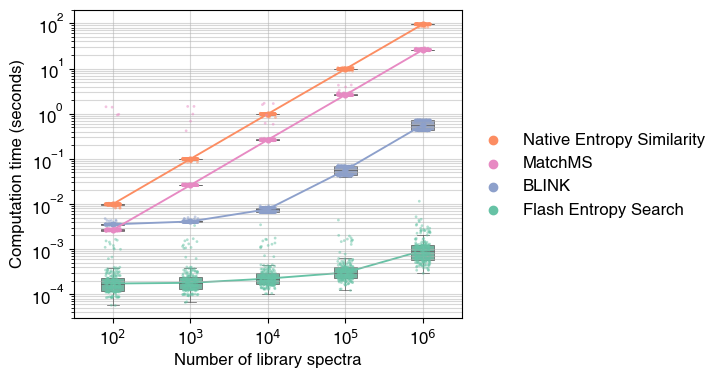

In [3]:
df_data = df[["library_size", "fast_entropy_search", "native_entropy_search", "blink", "matchms"]]


# For plotting, we need to convert the data from wide to long format
df_plot = df_data.melt(id_vars=["library_size"], var_name="method", value_name="time")
df_plot["library_size"] = df_plot["library_size"].astype(int)

#################### Plotting ####################
color_palette_set2 = sns.color_palette("Set2", 4)
color_palette={
    "native_entropy_search": color_palette_set2[1],
    "matchms": color_palette_set2[3],
    "blink": color_palette_set2[2],
    "fast_entropy_search": color_palette_set2[0],
}
fig, ax = plt.subplots(figsize=(5, 4))

# Add boxplots with matplotlib
sns.boxplot(x="library_size", y="time", hue="method", data=df_plot, palette=color_palette, dodge=False, linewidth=0.5, width=0.3, fliersize=0)

# # # Add lines for the median
sns.pointplot(x="library_size", y="time", hue="method", data=df_plot, palette=color_palette,
              estimator=np.median, dodge=False, join=True, errorbar=None, scale=0.5, errwidth=1)

sns.stripplot(x="library_size", y="time", hue="method", data=df_plot, palette=color_palette,
              dodge=False, jitter=True, size=2, alpha=0.5, linewidth=0)

# Add grid
plt.grid(True, which="both", ls="-", alpha=0.5)

# Set y-axis to log scale
plt.yscale("log")
# Set y-axis title
plt.ylabel("Computation time (seconds)")
plt.ylim(3e-5, 200)

# Change x-axis labels
ax.set_xticklabels(["10$^{}$".format(int(np.log10(int(x.get_text())))) for x in ax.get_xticklabels()])
plt.xlabel("Number of library spectra")

# Change legend
handles, labels = ax.get_legend_handles_labels()
legend_dict = {l: h for h, l in zip(handles, labels)}
labels_new = ["Native Entropy Similarity", "MatchMS", "BLINK", "Flash Entropy Search"]
handles_new = [legend_dict[l] for l in ["native_entropy_search", "matchms", "blink", "fast_entropy_search"]]
ax.legend(handles_new, labels_new, frameon=False, loc="upper left", bbox_to_anchor=(1, 0.65))
# Move legend to the top
# ax.legend(handles_new, labels_new, frameon=False, loc="upper center",ncol=2, bbox_to_anchor=(0.4, 1.25))

# Save figure
plt.savefig(path_figures / f"10_comparision_of_detailed_time-{datasource}.svg", bbox_inches="tight", dpi=1200)

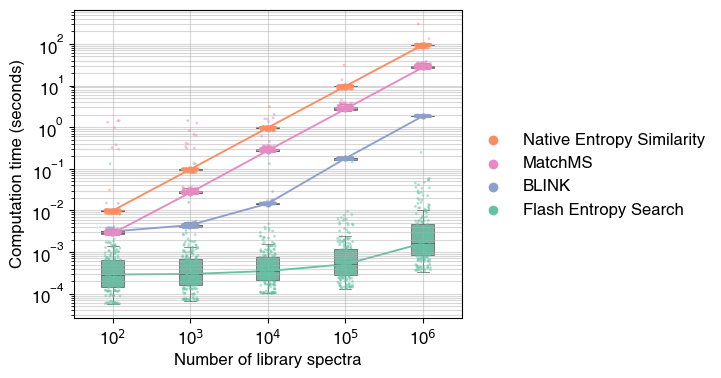

In [4]:
datasource = "gnps"

all_df = []
for file_data in (path_data/datasource/"benchmark_result").glob("*.csv"):
    df = pd.read_csv(file_data)
    df['file'] = file_data.stem
    all_df.append(df)

df = pd.concat(all_df)

df["charge"] = df["file"].str.extract(r"charge_(..?)-")
df["library_size"] = df["file"].str.extract(r"against_(.+)$").astype(int)

df_data = df[["library_size", "fast_entropy_search", "native_entropy_search", "blink", "matchms"]]


# For plotting, we need to convert the data from wide to long format
df_plot = df_data.melt(id_vars=["library_size"], var_name="method", value_name="time")
df_plot["library_size"] = df_plot["library_size"].astype(int)

#################### Plotting ####################
fig, ax = plt.subplots(figsize=(5, 4))

# Add boxplots with matplotlib
sns.boxplot(x="library_size", y="time", hue="method", data=df_plot, palette=color_palette, dodge=False, linewidth=0.5, width=0.3, fliersize=0)

# # # Add lines for the median
sns.pointplot(x="library_size", y="time", hue="method", data=df_plot, palette=color_palette,
              estimator=np.median, dodge=False, join=True, errorbar=None, scale=0.5, errwidth=1)

sns.stripplot(x="library_size", y="time", hue="method", data=df_plot, palette=color_palette,
              dodge=False, jitter=True, size=2, alpha=0.5, linewidth=0)

# Add grid
plt.grid(True, which="both", ls="-", alpha=0.5)

# Set y-axis to log scale
plt.yscale("log")
# Set y-axis title
plt.ylabel("Computation time (seconds)")
# plt.ylim(6e-5, 200)

# Change x-axis labels
ax.set_xticklabels(["10$^{}$".format(int(np.log10(int(x.get_text())))) for x in ax.get_xticklabels()])
plt.xlabel("Number of library spectra")

# Change legend
handles, labels = ax.get_legend_handles_labels()
legend_dict = {l: h for h, l in zip(handles, labels)}
labels_new = ["Native Entropy Similarity", "MatchMS", "BLINK", "Flash Entropy Search"]
handles_new = [legend_dict[l] for l in ["native_entropy_search", "matchms", "blink", "fast_entropy_search"]]
ax.legend(handles_new, labels_new, frameon=False, loc="upper left", bbox_to_anchor=(1, 0.65))


# Save figure
plt.savefig(path_figures / f"10_comparision_of_detailed_time-{datasource}.svg", bbox_inches="tight", dpi=1200)


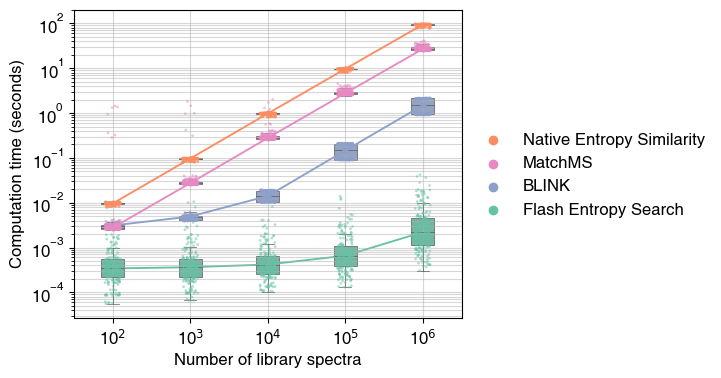

In [5]:
datasource = "public_repository"

all_df = []
for file_data in (path_data/datasource/"benchmark_result").glob("*.csv"):
    df = pd.read_csv(file_data)
    df['file'] = file_data.stem
    all_df.append(df)

df = pd.concat(all_df)

df["charge"] = df["file"].str.extract(r"charge_(..?)-")
df["library_size"] = df["file"].str.extract(r"against_(.+)$").astype(int)

df_data = df[["library_size", "fast_entropy_search", "native_entropy_search", "blink", "matchms"]]


# For plotting, we need to convert the data from wide to long format
df_plot = df_data.melt(id_vars=["library_size"], var_name="method", value_name="time")
df_plot["library_size"] = df_plot["library_size"].astype(int)

#################### Plotting ####################
fig, ax = plt.subplots(figsize=(5, 4))

# Add boxplots with matplotlib
sns.boxplot(x="library_size", y="time", hue="method", data=df_plot, palette=color_palette, dodge=False, linewidth=0.5, width=0.3, fliersize=0)

# # # Add lines for the median
sns.pointplot(x="library_size", y="time", hue="method", data=df_plot, palette=color_palette,
              estimator=np.median, dodge=False, join=True, errorbar=None, scale=0.5, errwidth=1)

sns.stripplot(x="library_size", y="time", hue="method", data=df_plot, palette=color_palette,
              dodge=False, jitter=True, size=2, alpha=0.5, linewidth=0)

# Add grid
plt.grid(True, which="both", ls="-", alpha=0.5)

# Set y-axis to log scale
plt.yscale("log")
# Set y-axis title
plt.ylabel("Computation time (seconds)")
# plt.ylim(6e-5, 200)

# Change x-axis labels
ax.set_xticklabels(["10$^{}$".format(int(np.log10(int(x.get_text())))) for x in ax.get_xticklabels()])
plt.xlabel("Number of library spectra")

# Change legend
handles, labels = ax.get_legend_handles_labels()
legend_dict = {l: h for h, l in zip(handles, labels)}
labels_new = ["Native Entropy Similarity", "MatchMS", "BLINK", "Flash Entropy Search"]
handles_new = [legend_dict[l] for l in ["native_entropy_search", "matchms", "blink", "fast_entropy_search"]]
ax.legend(handles_new, labels_new, frameon=False, loc="upper left", bbox_to_anchor=(1, 0.65))

# Save figure
plt.savefig(path_figures / f"10_comparision_of_detailed_time-{datasource}.svg", bbox_inches="tight", dpi=1200)
